# Teste de parâmetros | $L$

Esse notebook irá explorar a como a variação do parâmtero $L$ afeta os cálculos do MPM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [2]:
def unpack_metabolites(metabolites : dict, B0 : float, met_slice : int = 15, return_deltas : bool = False):
    """Unpacks metabolite information from the METABOLITES variable. 
    
    Parameters
    ----------
    metabolites : dict
        METABOLITES information.
    B0 : float [T]
        Magnetic field for the frequencies calculation.
    met_slice : int = `15`
        Number of metabolites to account in the final array. Default is the maximum number of available metabolites, `15`.
    return_deltas : bool = `False`
        Whether to return the deltas instead of the frequencies of the metabolites. Default is `False`."""
    deltas = np.array( list(metabolites.values()) )[:met_slice, 0]
    t2s = np.array( list(metabolites.values()) )[:met_slice, 1]
    M_0s = np.array( list(metabolites.values()) )[:met_slice, 2]

    ws = pymri.hz_to_rad( pymri.f_from_chem_shift(deltas, B0) )
    if return_deltas == False:
        return ws, t2s, M_0s
    else:
        return deltas, t2s, M_0s
    
def setup_sim_t(t0 : float, tn : float, n_points : int, B0 : float, return_extra : bool = False):
    """Setups the simulation time parameters.
    
    Parameters
    ----------
    
    t0 : float  [s]
        Initial time.
    tn : float  [s]
        Final time.
    n_points : int 
        Number of points of the simulation.
    B0 : float  [T]
        Magnetic file.
    return_extra : bool = `False`
        Whether to return the time interval `Dt` and the sampling frequency `sampling_f`. Default is `False`."""
    Dt = tn - t0
    dt = (tn - t0)/n_points 
    sampling_f = 1.0/dt # cycles/s
    if return_extra == False:
        return t0, tn, dt, B0
    else:
        return t0, tn, dt, B0, Dt, sampling_f


In [3]:
rerun = True
filename_end = ""
folder_name = "files/"

angle = (0)*np.pi

In [4]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = unpack_metabolites(metabolites, B0)
spins_phi = np.ones_like(M_0s)*angle

rcond = 1e-7 
zero_filtering = 1e-10

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


All frequencies are captured by the sampling rate.


In [5]:
def plot_chem_shifts(freqs : np.ndarray, 
                     sig_fft : np.ndarray, 
                     percentage : float, 
                     title : str = "Simulated MRS Spectra", 
                     xlabel : str = "δ (p.p.m.)",
                     ylabel : str = "Intensity (A.U.)",
                     c : str = "deeppink",
                     label : str = None): 
    """Plots a given spectrum in terms of its chemical shifts.
    
    Parameters
    ----------
    freqs : np.ndarray
    Frequencies array.
    sig_fft : np.ndarray
    Signal spectrum array.
    percentage : float (0.0, 1.0]
    Percentage of the signal to be displayed.
    title : str = `"Simulated MRS Spectra"`
    Title of the plot.
    xlabel : str = `"δ (p.p.m.)"`
    X-label of the plot.
    ylabel : str = `"Intensity (A.U.)"`
    y-label of the plot.
    c : str = `"deeppink"`
    Matplotlib color of the plot.
    label : str = `None`
    Label of the plot"""
    plot_freqs = freqs[freqs.size//2:] # +1 excludes de 0 frequency
    plot_sig_fft = sig_fft[sig_fft.size//2:]

    b = int(percentage*plot_freqs.size)

    plt.plot(plot_freqs[:b], plot_sig_fft[:b].real, c = c, label = label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if plt.gca().xaxis_inverted() == False:
      plt.gca().invert_xaxis() #inverts the x axis
    plt.grid(True)

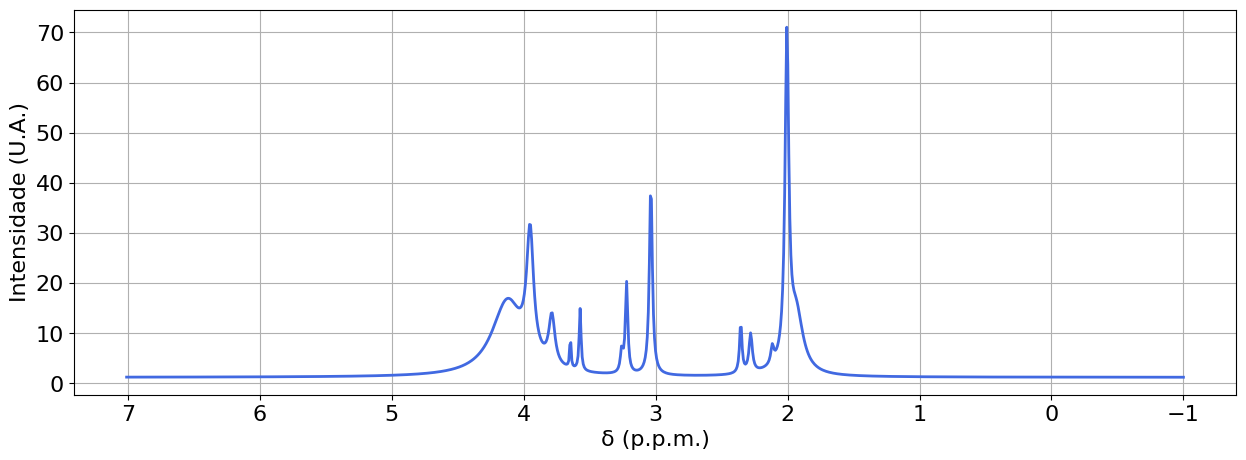

In [17]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)


sig, t = pymri.population_transverse_decay(t0, tn, dt, pop, np.array([]))
freqs, sig_fft = pymri.fourier_spectrum(sig, dt, B0)

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

pymri.plot_chem_shifts(freqs, sig_fft, 1.0, plot_type="real", c = "royalblue", linewidth=2, title = None, ylabel="Intensidade (U.A.)")

In [15]:
L = np.arange(start = 0.2, stop = 0.8, step = 0.05)
print(L)

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ]


In [16]:
reconstructed_sig, z, r = pymri.filter_sig( sig, 0.4, 1e-30, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True)

In [9]:
print(r)

[-0.74275873+0.35769375j -0.26947979+0.12977463j -0.09496212+0.04573135j
 -0.01351453+0.00650826j -0.03702982+0.01783262j -0.01819957+0.00876445j
 -0.06991518+0.03366938j -0.18253629+0.08790485j -0.03847137+0.01852684j
 -0.0406337 +0.01956816j -0.26281262+0.12656389j -0.38642555+0.18609274j
 -0.01657783+0.00798346j -0.0261281 +0.01258263j]


In [17]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)

s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)
M_0s, spins_phi, ws, t2s = np.sort(M_0s), np.sort(spins_phi), np.sort(ws), np.sort(t2s)


In [18]:
print(phi)
print(spins_phi)

[5.49778714 5.49778714 5.49778714 5.49778714 5.49778714 5.49778714
 5.49778714 5.49778714 5.49778714 5.49778714 5.49778714 5.49778714
 5.49778714 5.49778714]
[5.49778714 5.49778714 5.49778714 5.49778714 5.49778714 5.49778714
 5.49778714 5.49778714 5.49778714 5.49778714 5.49778714 5.49778714
 5.49778714 5.49778714]


In [12]:
with np.printoptions(threshold=np.inf):
    print("Generated X Original")
    print("Frequencias :\t", RMSE(omega, ws))
    print("T2s :\t\t", RMSE(gen_t2, t2s))
    print("M0s : \t\t", RMSE(s0, M_0s))
    print("Fases : \t", RMSE(phi, spins_phi))

Generated X Original
Frequencias :	 1.9018398826430643e-11
T2s :		 4.8719842598707464e-14
M0s : 		 3.9328247152158894e-14
Fases : 	 9.889278707095641e-13


In [13]:
avgs = 10
               # (variaveis, numero de Ls, médias)
RMSEs = np.zeros((5, L.size, avgs))

In [14]:
if rerun == True:
    for i in range(L.size):
        for j in range(avgs):
            reconstructed_sig, z, r = pymri.filter_sig( sig, L[i], 1e-15, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True )

            s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
            s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)

            RMSEs[0, i, j] = RMSE(omega, ws)
            RMSEs[1, i, j] = RMSE(gen_t2, t2s)
            RMSEs[2, i, j] = RMSE(s0, M_0s)
            RMSEs[3, i, j] = RMSE(phi, spins_phi)
            RMSEs[4, i, j] = RMSE(np.abs(reconstructed_sig), np.abs(sig))

In [15]:
if rerun == True:
    file = open(folder_name + "l_testing_avg" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.6f}' for x in L) + "\n")

    avg_RMSEs = np.average(RMSEs, axis = 2)
    file.write(",".join(str(x) for x in avg_RMSEs[0, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[1, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[2, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[3, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[4, :]))

    file.close()

    file = open(folder_name + "l_testing_std" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.6f}' for x in L) + "\n")

    std_RMSEs = np.std(RMSEs, axis=2)
    file.write(",".join(str(x) for x in std_RMSEs[0, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[1, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[2, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[3, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[4, :]))

    file.close()

In [18]:
# If simulation is lost
if(rerun == False):
    file_in = pd.read_csv(folder_name + "l_testing_avg" + filename_end + ".csv")

    L = file_in.keys().to_numpy(dtype=np.float64)
    avg_RMSEs = file_in.values

    file_in = pd.read_csv(folder_name + "l_testing_std" + filename_end + ".csv")
    std_RMSEs = file_in.values

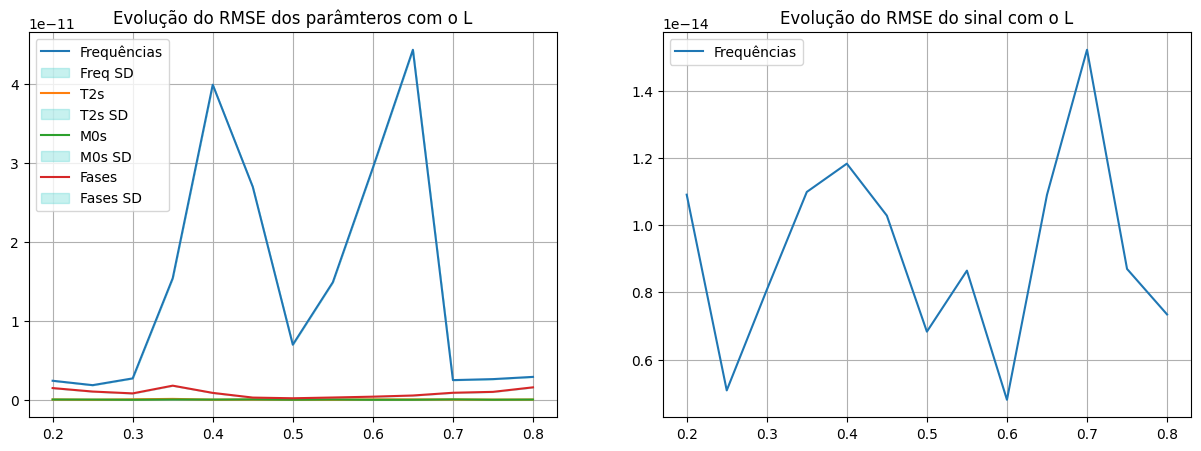

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(L, avg_RMSEs[0], label = "Frequências")
plt.fill_between(L, avg_RMSEs[0] - std_RMSEs[0], avg_RMSEs[0] + std_RMSEs[0], alpha = 0.3, color = "mediumturquoise", label = "Freq SD")
plt.plot(L, avg_RMSEs[1], label = "T2s")
plt.fill_between(L, avg_RMSEs[1] - std_RMSEs[1], avg_RMSEs[1] + std_RMSEs[1], alpha = 0.3, color = "mediumturquoise", label = "T2s SD")
plt.plot(L, avg_RMSEs[2], label = "M0s")
plt.fill_between(L, avg_RMSEs[2] - std_RMSEs[2], avg_RMSEs[2] + std_RMSEs[2], alpha = 0.3, color = "mediumturquoise", label = "M0s SD")
plt.plot(L, avg_RMSEs[3], label = "Fases")
plt.fill_between(L, avg_RMSEs[3] - std_RMSEs[3], avg_RMSEs[3] + std_RMSEs[3], alpha = 0.3, color = "mediumturquoise", label = "Fases SD")
plt.title("Evolução do RMSE dos parâmteros com o L")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title("Evolução do RMSE do sinal com o L")
plt.plot(L, avg_RMSEs[4], label = "Frequências")
plt.grid()
plt.legend()